# SMYLE: NH SIV (Sea Ice Volume) Skill 

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
from functools import partial
import glob
import dask
import matplotlib.pyplot as plt
%matplotlib inline

# SMYLE Utility functions
from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io

## Create Dask Cluster

In [41]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

distributed.core - ERROR - Exception while handling op register-client
Traceback (most recent call last):
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/core.py", line 502, in handle_comm
    result = await result
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5249, in add_client
    self.remove_client(client=client)
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5276, in remove_client
    self.client_releases_keys(
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 5014, in client_releases_keys
    self.transitions(recommendations)
  File "/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 7119, in transitions
    self.send_all(client_msgs, worker_msgs)
  File "/glade/wor

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(20) #adapt(minimum_jobs=0, maximum_jobs=24)

In [4]:
cluster

# Data Intake:

In [6]:
def preprocessor(d0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for your analysis to speed up processing. 
    
    Here,
        - reset monthly time to mid-month value
        - select top vertical level and only nlead time values
        - drop fields unrelated to SST
    """
    d0 = cal.time_set_midmonth(d0,'time')
    d0 = d0.isel(time=slice(0, nlead))
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field,'time','TLAT','TLON','tarea']].drop(['ULAT','ULON'])
    d0 = d0.chunk({'L':-1})
    return d0

In [7]:
%%time
# SMYLE-Nov ice thickness data
field = 'hi'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cice.h.'
filetemplate = datadir+casename+'/ice/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 11
#chunks={'z_t':1,'nlat':80}
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle11.nbytes/1e9 #GB

CPU times: user 17.8 s, sys: 9.26 s, total: 27.1 s
Wall time: 33.1 s


11.562035112

In [8]:
%%time
smyle11_seas = cal.mon_to_seas_dask2(smyle11).persist()

CPU times: user 9.2 s, sys: 132 ms, total: 9.33 s
Wall time: 9.81 s


In [9]:
%%time
# SMYLE-Feb 
field = 'hi'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cice.h.'
filetemplate = datadir+casename+'/ice/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 2
#chunks={'z_t':1,'nlat':80}
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle02.nbytes/1e9 #GB

CPU times: user 35.1 s, sys: 9.61 s, total: 44.8 s
Wall time: 50 s


11.562035112

In [10]:
%%time
smyle02_seas = cal.mon_to_seas_dask2(smyle02).persist()

CPU times: user 10.9 s, sys: 127 ms, total: 11 s
Wall time: 11.5 s


In [11]:
%%time
# SMYLE-May 
field = 'hi'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cice.h.'
filetemplate = datadir+casename+'/ice/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 5
#chunks={'z_t':1,'nlat':80}
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle05.nbytes/1e9 #GB

CPU times: user 39.5 s, sys: 9.9 s, total: 49.4 s
Wall time: 55 s


11.562035112

In [12]:
%%time
smyle05_seas = cal.mon_to_seas_dask2(smyle05).persist()

CPU times: user 10.7 s, sys: 146 ms, total: 10.8 s
Wall time: 11.5 s


In [13]:
%%time
# SMYLE-Aug 
field = 'hi'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.cice.h.'
filetemplate = datadir+casename+'/ice/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startmonth = 8
#chunks={'z_t':1,'nlat':80}
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
smyle08.nbytes/1e9 #GB

CPU times: user 45.3 s, sys: 9.82 s, total: 55.1 s
Wall time: 1min 1s


11.562035112

In [14]:
%%time
smyle08_seas = cal.mon_to_seas_dask2(smyle08).persist()

CPU times: user 10.6 s, sys: 132 ms, total: 10.8 s
Wall time: 11.4 s


In [15]:
smyle08_seas

<xarray.Dataset>
Dimensions:  (nj: 384, ni: 320, L: 8, Y: 49, M: 20)
Coordinates:
    TLAT     (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLON     (nj, ni) float32 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
  * L        (L) int64 1 4 7 10 13 16 19 22
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2014 2015 2016 2017 2018
  * M        (M) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
Dimensions without coordinates: nj, ni
Data variables:
    hi       (Y, L, M, nj, ni) float64 dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tarea    (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    time     (Y, L) object dask.array<chunksize=(1, 8), meta=np.ndarray>
Attributes:
    title:             b.e21.BSMYLE.f09_g17.1970-08.001
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    comment:           All years have exactly 365 days
    comment2:          File written on model date 19700901
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2021-04-20 at 16:01
    io_flavor:         io_pio

### Get CESM2-LE members

In [16]:
import intake

catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
col = intake.open_esm_datastore(catalog_file)
cesm2data = col.search(component='ice', 
                       variable=['hi'], 
                       frequency='month_1', 
                       experiment=['historical','ssp370'], 
                       forcing_variant='smbb')

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [17]:
## The following is needed as a workaround for this issue with intake-esm:
## https://github.com/intake/intake-esm/issues/343
cesm2data.df = cesm2data.df.sort_values(by=['time_range'])

# Test that it gets timestamps in order:
#cesm2data.df[cesm2data.df.experiment == 'historical']

In [18]:
%%time
## Use preprocessor to return mid-month time
def preproc(ds):
    ds = cal.time_set_midmonth(ds,'time')
    return ds

dask.config.set(**{'array.slicing.split_large_chunks': True})
dsets = cesm2data.to_dataset_dict(preprocess=preproc)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 16.8 s, sys: 689 ms, total: 17.4 s
Wall time: 24.4 s


In [19]:
dsets.keys()

dict_keys(['ice.ssp370.cice.h.smbb.hi', 'ice.historical.cice.h.smbb.hi'])

In [20]:
# Compute CESM2-LE hi, mean over 50 members:
cesm2_hist = dsets['ice.historical.cice.h.smbb.hi'].hi
cesm2_ssp = dsets['ice.ssp370.cice.h.smbb.hi'].hi
cesm2_hi = xr.concat([cesm2_hist,cesm2_ssp],dim='time').mean('member_id').persist()

### Compute SMYLE NH SIV

In [21]:
# Define latitude bounds for computing SIE
lat1 = 40.
lat2 = 90.

In [22]:
def POP_regional_areawgt(ds,lon_lim,lat_lim):
    tarea = (ds.tarea/(1000.**2)).load()
    tarea['units'] = 'km^2'
    tlat = ds.TLAT
    tlon = xr.where(ds.TLON>180.,ds.TLON-360.,ds.TLON)
    region = (tlat>=lat_lim[0]) & (tlat<=lat_lim[1]) & (tlon>=lon_lim[0]) & (tlon<=lon_lim[1])
    return xr.where(region,tarea.fillna(0),0)

In [23]:
POPg16_arctic_area = POP_regional_areawgt(smyle11_seas,[-180.,180.],[lat1,lat2])

- Here, perform actual computation, returning xarray

In [24]:
%%time
m_to_km = 0.001
smyle11_siv = (smyle11_seas.hi*m_to_km*POPg16_arctic_area).sum(("ni", "nj")).load()
smyle11_time = smyle11_seas.time.load()
smyle02_siv = (smyle02_seas.hi*m_to_km*POPg16_arctic_area).sum(("ni", "nj")).load()
smyle02_time = smyle02_seas.time.load()
smyle05_siv = (smyle05_seas.hi*m_to_km*POPg16_arctic_area).sum(("ni", "nj")).load()
smyle05_time = smyle05_seas.time.load()
smyle08_siv = (smyle08_seas.hi*m_to_km*POPg16_arctic_area).sum(("ni", "nj")).load()
smyle08_time = smyle08_seas.time.load()

CPU times: user 1min 10s, sys: 1 s, total: 1min 11s
Wall time: 1min 16s


### Compute CESM2-LE NH SIV

In [25]:
cesm2_siv = (cesm2_hi*m_to_km*POPg16_arctic_area).sum(("ni", "nj")).load()

In [26]:
cesm2_siv_seas = cesm2_siv.rolling(time=3,min_periods=3, center=True).mean()

### Compute SMYLE-FOSI NH SIV

In [27]:
ds_fosi = xr.open_dataset('/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ice/proc/tseries/month_1/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.cice.h.hi.030601-036812.nc')
fosi_montime = [cftime.DatetimeNoLeap(1958+year, 1+month, 15) for year in range(63) for month in range(12)]
ds_fosi['time'] = fosi_montime
fosi_siv = (ds_fosi.hi*m_to_km*POPg16_arctic_area).sum(("ni", "nj"))

In [28]:
fosi_siv_seas = fosi_siv.rolling(time=3,min_periods=3, center=True).mean()

### Compute PIOMAS NH SIV

In [29]:
# PIOMAS Gridded Sea Ice Thickness
#ds_obs = xr.open_dataset('/glade/p/cgd/oce/people/yeager/obs/seaice/PIOMAS/PIOMAS.hi.1978-2020.nc',decode_times=False)
#ds_obs['time'] = [cftime.DatetimeNoLeap(1978+year, 1+month, 15) for year in range(43) for month in range(12)]
#obs_hi = ds_obs.hi

# PIOMAS Monthly SIV
fin = '/glade/p/cgd/oce/people/yeager/obs/seaice/PIOMAS/PIOMAS.icevolume.1979-2021.txt'
f = open(fin, 'r')  # We need to re-open the file
xrlist = []
for line in f:
    line = line.strip()
    columns = line.split()
    year = int(columns[0])
    montime = [cftime.DatetimeNoLeap(year, 1+month, 15) for month in range(12)]
    data = [float(columns[i+1])*1000. for i in range(12)]
    siv = xr.DataArray(data,dims=["time"],coords={"time":montime},attrs={"units":"km^3"})
    xrlist.append(siv)
piomas_siv = xr.concat(xrlist,"time")

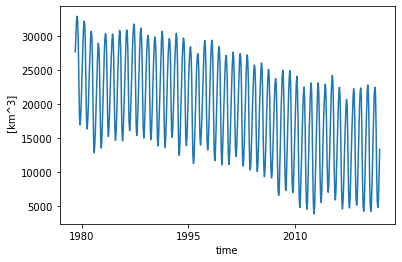

In [30]:
piomas_siv.plot()

In [31]:
obs_siv_seas = piomas_siv.rolling(time=3,min_periods=3, center=True).mean()

# Plots

In [32]:
# Skill Score Functions
import xskillscore as xs

def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

def leadtime_skill_byseas(mod_da,mod_time,obs_da,cy0,cy1,detrend=False):
    ens = mod_da.mean('M')
    seasons = {2:'JFM',5:'AMJ',8:'JAS',11:'OND'}
    r_list = []
    p_list = []
    e_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time_year = mod_time.sel(L=i).dt.year.data
        ens_time_month = mod_time.sel(L=i).dt.month.data[0]
        obs_time_month = obs_da.time.dt.month
        obs_time_year = obs_da.time.dt.year
        obs_ts = obs_da.where(obs_time_month==ens_time_month).dropna('time')
        ens_ts = ens_ts.assign_coords(time=("time",ens_time_year))
        obs_ts = obs_ts.assign_coords(time=("time",obs_ts.time.dt.year.data))
        obs_ts = obs_ts.assign_coords({"season":seasons[ens_time_month]})
        obs_ts = obs_ts - obs_ts.sel(time=slice(cy0,cy1)).mean('time')
        a,b = xr.align(ens_ts,obs_ts)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
        r = xs.pearson_r(a,b,dim='time')
        e = xs.rmse(a,b,dim='time')/b.std('time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r_list.append(r)
        e_list.append(e)
        p_list.append(p)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    rmse = xr.concat(e_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval,'rmse':rmse})

In [33]:
def leadtime_skill_byseas_withLE(mod_da,mod_time,obs_da,le_da,cy0,cy1,detrend=False):
    ens = mod_da.mean('M')
    seasons = {2:'JFM',5:'AMJ',8:'JAS',11:'OND'}
    r_list = []
    p_list = []
    e_list = []
    r2_list = []
    p2_list = []
    e2_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time_year = mod_time.sel(L=i).dt.year.data
        ens_time_month = mod_time.sel(L=i).dt.month.data[0]
        obs_time_month = obs_da.time.dt.month
        obs_time_year = obs_da.time.dt.year
        le_time_month = le_da.time.dt.month
        le_time_year = le_da.time.dt.year
        obs_ts = obs_da.where(obs_time_month==ens_time_month).dropna('time')
        obs_ts = obs_ts.assign_coords(time=("time",obs_ts.time.dt.year.data))
        obs_ts = obs_ts.assign_coords({"season":seasons[ens_time_month]})
        obs_ts = obs_ts - obs_ts.sel(time=slice(cy0,cy1)).mean('time')
        le_ts = le_da.where(le_time_month==ens_time_month).dropna('time')
        le_ts = le_ts.assign_coords(time=("time",le_ts.time.dt.year.data))
        le_ts = le_ts.assign_coords({"season":seasons[ens_time_month]})
        le_ts = le_ts - le_ts.sel(time=slice(cy0,cy1)).mean('time')
        ens_ts = ens_ts.assign_coords(time=("time",ens_time_year))
        a,b = xr.align(ens_ts,obs_ts)
        c,d = xr.align(le_ts,b)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
                c = detrend_linear(c,'time')
        r = xs.pearson_r(a,b,dim='time')
        e = xs.rmse(a,b,dim='time')/b.std('time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r2 = xs.pearson_r(c,b,dim='time')
        e2 = xs.rmse(c,b,dim='time')/b.std('time')
        p2 = xs.pearson_r_eff_p_value(c,b,dim='time')
        r_list.append(r)
        e_list.append(e)
        p_list.append(p)
        r2_list.append(r2)
        e2_list.append(e2)
        p2_list.append(p2)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    rmse = xr.concat(e_list,ens.L)
    corr2 = xr.concat(r2_list,ens.L)
    pval2 = xr.concat(p2_list,ens.L)
    rmse2 = xr.concat(e2_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval,'rmse':rmse,'corr2':corr2,'pval2':pval2,'rmse2':rmse2})

### De-drift SMYLE data:

In [34]:
%%time
# Remove leadtime-dependent drift, using the following years for climatology:
climy0 = 1980
climy1 = 2015
smyle11_siv_dd,smyle11_siv_drift = stat.remove_drift(smyle11_siv,smyle11_time,climy0,climy1)
smyle02_siv_dd,smyle02_siv_drift = stat.remove_drift(smyle02_siv,smyle02_time,climy0,climy1)
smyle05_siv_dd,smyle05_siv_drift = stat.remove_drift(smyle05_siv,smyle05_time,climy0,climy1)
smyle08_siv_dd,smyle08_siv_drift = stat.remove_drift(smyle08_siv,smyle08_time,climy0,climy1)

CPU times: user 12.1 ms, sys: 25 µs, total: 12.1 ms
Wall time: 12.1 ms


### Compute Skill Scores:

In [35]:
%%time
# Correlation as a function of forecast lead month:
smyle11_skill = leadtime_skill_byseas_withLE(smyle11_siv_dd,smyle11_time,obs_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle02_skill = leadtime_skill_byseas_withLE(smyle02_siv_dd,smyle02_time,obs_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle05_skill = leadtime_skill_byseas_withLE(smyle05_siv_dd,smyle05_time,obs_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle08_skill = leadtime_skill_byseas_withLE(smyle08_siv_dd,smyle08_time,obs_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle11_skill_dt = leadtime_skill_byseas_withLE(smyle11_siv_dd,smyle11_time,obs_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle02_skill_dt = leadtime_skill_byseas_withLE(smyle02_siv_dd,smyle02_time,obs_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle05_skill_dt = leadtime_skill_byseas_withLE(smyle05_siv_dd,smyle05_time,obs_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle08_skill_dt = leadtime_skill_byseas_withLE(smyle08_siv_dd,smyle08_time,obs_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encoun

CPU times: user 2.42 s, sys: 15.4 ms, total: 2.44 s
Wall time: 2.52 s


In [36]:
%%time
# Correlation as a function of forecast lead month:
smyle11_fskill = leadtime_skill_byseas_withLE(smyle11_siv_dd,smyle11_time,fosi_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle02_fskill = leadtime_skill_byseas_withLE(smyle02_siv_dd,smyle02_time,fosi_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle05_fskill = leadtime_skill_byseas_withLE(smyle05_siv_dd,smyle05_time,fosi_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle08_fskill = leadtime_skill_byseas_withLE(smyle08_siv_dd,smyle08_time,fosi_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=False).isel(L=slice(1,None))
smyle11_fskill_dt = leadtime_skill_byseas_withLE(smyle11_siv_dd,smyle11_time,fosi_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle02_fskill_dt = leadtime_skill_byseas_withLE(smyle02_siv_dd,smyle02_time,fosi_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle05_fskill_dt = leadtime_skill_byseas_withLE(smyle05_siv_dd,smyle05_time,fosi_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))
smyle08_fskill_dt = leadtime_skill_byseas_withLE(smyle08_siv_dd,smyle08_time,fosi_siv_seas,cesm2_siv_seas,climy0,climy1,detrend=True).isel(L=slice(1,None))

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encoun

CPU times: user 2.55 s, sys: 14.6 ms, total: 2.57 s
Wall time: 2.62 s


/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in double_scalars
  _x = dof / (dof + t_squared)
/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encoun

(0.0, 1.0)

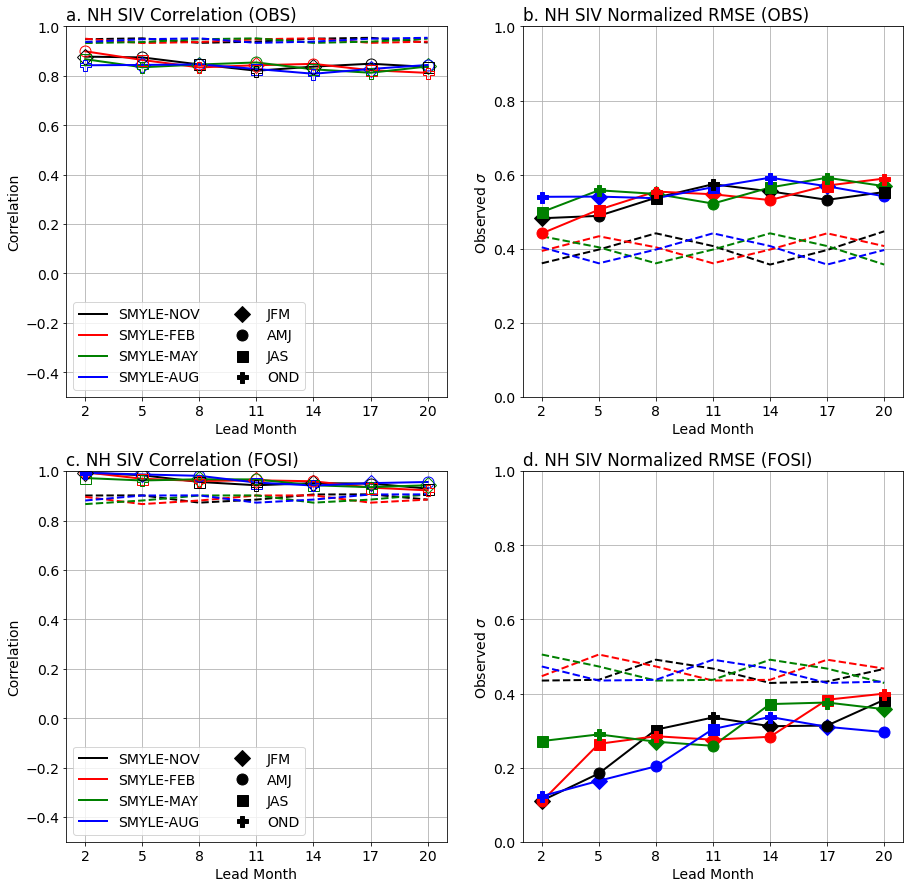

In [55]:
# plot correlation
fig = plt.figure(figsize=(15,15))
plt.rcParams['font.size'] = '14'
leadmon = smyle11_skill.L-2
seasons = ['JFM','AMJ','JAS','OND']
markers = ['D','o','s','P']
#seasons = ['JFM','JAS']
#markers = ['D','s']

ax = fig.add_subplot(2,2,1)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('a. NH SIV Correlation (OBS)',loc='left')
ax.plot(leadmon,smyle11_skill.corr,color='k',linewidth=2,label='SMYLE-NOV')
ax.plot(leadmon,smyle02_skill.corr,color='r',linewidth=2,label='SMYLE-FEB')
ax.plot(leadmon,smyle05_skill.corr,color='g',linewidth=2,label='SMYLE-MAY')
ax.plot(leadmon,smyle08_skill.corr,color='b',linewidth=2,label='SMYLE-AUG')
ax.plot(leadmon,smyle11_skill.corr2,color='k',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle02_skill.corr2,color='r',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle05_skill.corr2,color='g',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle08_skill.corr2,color='b',linewidth=2,linestyle='dashed')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_skill.corr.where(smyle11_skill.season==i),color='k',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle11_skill.corr.where(smyle11_skill.season==i).where(smyle11_skill.pval<0.1),color='k',marker=j,markersize=11,label=i,linestyle='None')
    ax.plot(leadmon,smyle02_skill.corr.where(smyle02_skill.season==i),color='r',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle02_skill.corr.where(smyle02_skill.season==i).where(smyle02_skill.pval<0.1),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_skill.corr.where(smyle05_skill.season==i),color='g',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle05_skill.corr.where(smyle05_skill.season==i).where(smyle05_skill.pval<0.1),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_skill.corr.where(smyle08_skill.season==i),color='b',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle08_skill.corr.where(smyle08_skill.season==i).where(smyle08_skill.pval<0.1),color='b',marker=j,markersize=11)
leg1 = ax.legend(loc='lower left',ncol=2)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([-0.5,1.])

ax = fig.add_subplot(2,2,2)
ax.set_ylabel(r'Observed $\sigma$', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('b. NH SIV Normalized RMSE (OBS)',loc='left')
ax.plot(leadmon,smyle11_skill.rmse,color='k',linewidth=2)
ax.plot(leadmon,smyle02_skill.rmse,color='r',linewidth=2)
ax.plot(leadmon,smyle05_skill.rmse,color='g',linewidth=2)
ax.plot(leadmon,smyle08_skill.rmse,color='b',linewidth=2)
ax.plot(leadmon,smyle11_skill.rmse2,color='k',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle02_skill.rmse2,color='r',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle05_skill.rmse2,color='g',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle08_skill.rmse2,color='b',linewidth=2,linestyle='dashed')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_skill.rmse.where(smyle11_skill.season==i),color='k',marker=j,markersize=11)
    ax.plot(leadmon,smyle02_skill.rmse.where(smyle02_skill.season==i),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_skill.rmse.where(smyle05_skill.season==i),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_skill.rmse.where(smyle08_skill.season==i),color='b',marker=j,markersize=11)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([0.,1.])

ax = fig.add_subplot(2,2,3)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('c. NH SIV Correlation (FOSI)',loc='left')
ax.plot(leadmon,smyle11_fskill.corr,color='k',linewidth=2,label='SMYLE-NOV')
ax.plot(leadmon,smyle02_fskill.corr,color='r',linewidth=2,label='SMYLE-FEB')
ax.plot(leadmon,smyle05_fskill.corr,color='g',linewidth=2,label='SMYLE-MAY')
ax.plot(leadmon,smyle08_fskill.corr,color='b',linewidth=2,label='SMYLE-AUG')
ax.plot(leadmon,smyle11_fskill.corr2,color='k',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle02_fskill.corr2,color='r',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle05_fskill.corr2,color='g',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle08_fskill.corr2,color='b',linewidth=2,linestyle='dashed')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_fskill.corr.where(smyle11_fskill.season==i),color='k',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle11_fskill.corr.where(smyle11_fskill.season==i).where(smyle11_fskill.pval<0.1),color='k',marker=j,markersize=11,label=i,linestyle='None')
    ax.plot(leadmon,smyle02_fskill.corr.where(smyle02_fskill.season==i),color='r',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle02_fskill.corr.where(smyle02_fskill.season==i).where(smyle02_fskill.pval<0.1),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_fskill.corr.where(smyle05_fskill.season==i),color='g',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle05_fskill.corr.where(smyle05_fskill.season==i).where(smyle05_fskill.pval<0.1),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_fskill.corr.where(smyle08_fskill.season==i),color='b',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle08_fskill.corr.where(smyle08_fskill.season==i).where(smyle08_fskill.pval<0.1),color='b',marker=j,markersize=11)
leg1 = ax.legend(loc='lower left',ncol=2)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([-0.5,1])

ax = fig.add_subplot(2,2,4)
ax.set_ylabel(r'Observed $\sigma$', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('d. NH SIV Normalized RMSE (FOSI)',loc='left')
ax.plot(leadmon,smyle11_fskill.rmse,color='k',linewidth=2)
ax.plot(leadmon,smyle02_fskill.rmse,color='r',linewidth=2)
ax.plot(leadmon,smyle05_fskill.rmse,color='g',linewidth=2)
ax.plot(leadmon,smyle08_fskill.rmse,color='b',linewidth=2)
ax.plot(leadmon,smyle11_fskill.rmse2,color='k',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle02_fskill.rmse2,color='r',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle05_fskill.rmse2,color='g',linewidth=2,linestyle='dashed')
ax.plot(leadmon,smyle08_fskill.rmse2,color='b',linewidth=2,linestyle='dashed')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_fskill.rmse.where(smyle11_fskill.season==i),color='k',marker=j,markersize=11)
    ax.plot(leadmon,smyle02_fskill.rmse.where(smyle02_fskill.season==i),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_fskill.rmse.where(smyle05_fskill.season==i),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_fskill.rmse.where(smyle08_fskill.season==i),color='b',marker=j,markersize=11)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([0.,1.])

(0.0, 1.0)

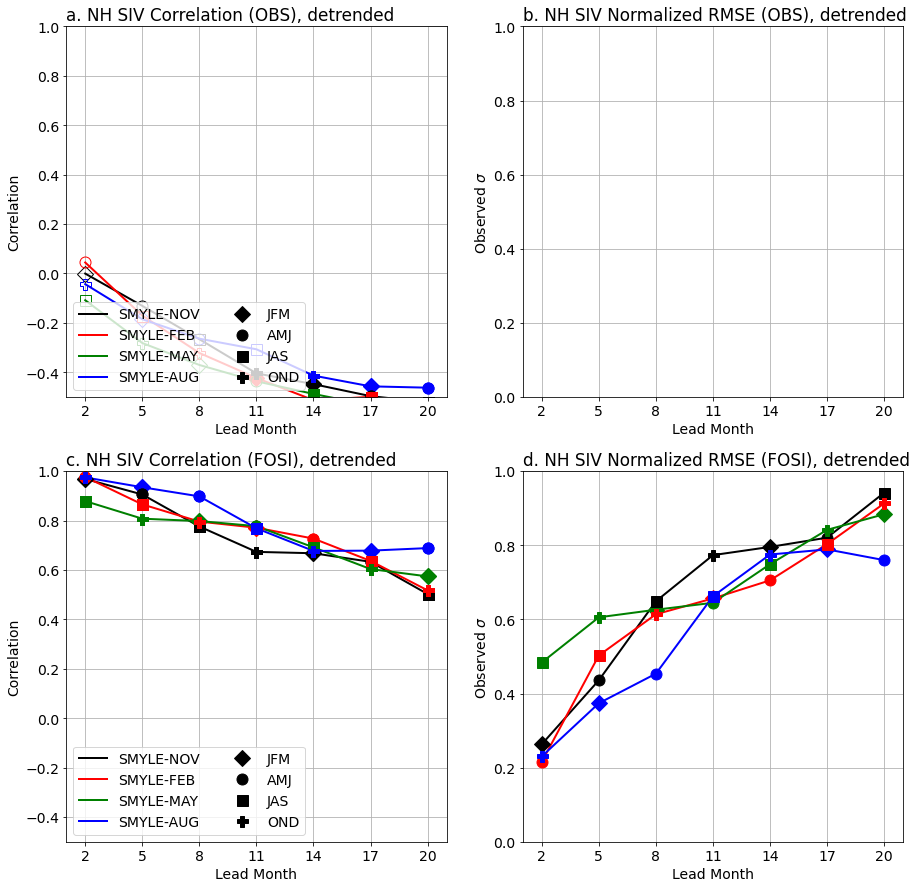

In [56]:
# plot correlation
fig = plt.figure(figsize=(15,15))
plt.rcParams['font.size'] = '14'
leadmon = smyle11_skill_dt.L-2
seasons = ['JFM','AMJ','JAS','OND']
markers = ['D','o','s','P']
#seasons = ['JFM','JAS']
#markers = ['D','s']

ax = fig.add_subplot(2,2,1)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('a. NH SIV Correlation (OBS), detrended',loc='left')
ax.plot(leadmon,smyle11_skill_dt.corr,color='k',linewidth=2,label='SMYLE-NOV')
ax.plot(leadmon,smyle02_skill_dt.corr,color='r',linewidth=2,label='SMYLE-FEB')
ax.plot(leadmon,smyle05_skill_dt.corr,color='g',linewidth=2,label='SMYLE-MAY')
ax.plot(leadmon,smyle08_skill_dt.corr,color='b',linewidth=2,label='SMYLE-AUG')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_skill_dt.corr.where(smyle11_skill_dt.season==i),color='k',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle11_skill_dt.corr.where(smyle11_skill_dt.season==i).where(smyle11_skill_dt.pval<0.1),color='k',marker=j,markersize=11,label=i,linestyle='None')
    ax.plot(leadmon,smyle02_skill_dt.corr.where(smyle02_skill_dt.season==i),color='r',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle02_skill_dt.corr.where(smyle02_skill_dt.season==i).where(smyle02_skill_dt.pval<0.1),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_skill_dt.corr.where(smyle05_skill_dt.season==i),color='g',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle05_skill_dt.corr.where(smyle05_skill_dt.season==i).where(smyle05_skill_dt.pval<0.1),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_skill_dt.corr.where(smyle08_skill_dt.season==i),color='b',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle08_skill_dt.corr.where(smyle08_skill_dt.season==i).where(smyle08_skill_dt.pval<0.1),color='b',marker=j,markersize=11)
leg1 = ax.legend(loc='lower left',ncol=2)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([-0.5,1])

ax = fig.add_subplot(2,2,2)
ax.set_ylabel(r'Observed $\sigma$', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('b. NH SIV Normalized RMSE (OBS), detrended',loc='left')
ax.plot(leadmon,smyle11_skill_dt.rmse,color='k',linewidth=2)
ax.plot(leadmon,smyle02_skill_dt.rmse,color='r',linewidth=2)
ax.plot(leadmon,smyle05_skill_dt.rmse,color='g',linewidth=2)
ax.plot(leadmon,smyle08_skill_dt.rmse,color='b',linewidth=2)
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_skill_dt.rmse.where(smyle11_skill_dt.season==i),color='k',marker=j,markersize=11)
    ax.plot(leadmon,smyle02_skill_dt.rmse.where(smyle02_skill_dt.season==i),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_skill_dt.rmse.where(smyle05_skill_dt.season==i),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_skill_dt.rmse.where(smyle08_skill_dt.season==i),color='b',marker=j,markersize=11)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([0.,1.])

ax = fig.add_subplot(2,2,3)
ax.set_ylabel('Correlation', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('c. NH SIV Correlation (FOSI), detrended',loc='left')
ax.plot(leadmon,smyle11_fskill_dt.corr,color='k',linewidth=2,label='SMYLE-NOV')
ax.plot(leadmon,smyle02_fskill_dt.corr,color='r',linewidth=2,label='SMYLE-FEB')
ax.plot(leadmon,smyle05_fskill_dt.corr,color='g',linewidth=2,label='SMYLE-MAY')
ax.plot(leadmon,smyle08_fskill_dt.corr,color='b',linewidth=2,label='SMYLE-AUG')
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_fskill_dt.corr.where(smyle11_fskill_dt.season==i),color='k',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle11_fskill_dt.corr.where(smyle11_fskill_dt.season==i).where(smyle11_fskill_dt.pval<0.1),color='k',marker=j,markersize=11,label=i,linestyle='None')
    ax.plot(leadmon,smyle02_fskill_dt.corr.where(smyle02_fskill_dt.season==i),color='r',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle02_fskill_dt.corr.where(smyle02_fskill_dt.season==i).where(smyle02_fskill_dt.pval<0.1),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_fskill_dt.corr.where(smyle05_fskill_dt.season==i),color='g',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle05_fskill_dt.corr.where(smyle05_fskill_dt.season==i).where(smyle05_fskill_dt.pval<0.1),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_fskill_dt.corr.where(smyle08_fskill_dt.season==i),color='b',marker=j,markersize=11,fillstyle='none')
    ax.plot(leadmon,smyle08_fskill_dt.corr.where(smyle08_fskill_dt.season==i).where(smyle08_fskill_dt.pval<0.1),color='b',marker=j,markersize=11)
leg1 = ax.legend(loc='lower left',ncol=2)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([-0.5,1])

ax = fig.add_subplot(2,2,4)
ax.set_ylabel(r'Observed $\sigma$', fontsize=14)
ax.set_xlabel('Lead Month')
ax.set_title('d. NH SIV Normalized RMSE (FOSI), detrended',loc='left')
ax.plot(leadmon,smyle11_fskill_dt.rmse,color='k',linewidth=2)
ax.plot(leadmon,smyle02_fskill_dt.rmse,color='r',linewidth=2)
ax.plot(leadmon,smyle05_fskill_dt.rmse,color='g',linewidth=2)
ax.plot(leadmon,smyle08_fskill_dt.rmse,color='b',linewidth=2)
for i,j in zip(seasons,markers):
    ax.plot(leadmon,smyle11_fskill_dt.rmse.where(smyle11_fskill_dt.season==i),color='k',marker=j,markersize=11)
    ax.plot(leadmon,smyle02_fskill_dt.rmse.where(smyle02_fskill_dt.season==i),color='r',marker=j,markersize=11)
    ax.plot(leadmon,smyle05_fskill_dt.rmse.where(smyle05_fskill_dt.season==i),color='g',marker=j,markersize=11)
    ax.plot(leadmon,smyle08_fskill_dt.rmse.where(smyle08_fskill_dt.season==i),color='b',marker=j,markersize=11)
ax.set_xticks(leadmon)
ax.grid(True)
ax.set_xlim([1,21])
ax.set_ylim([0.,1.])

### Time Series Plots

In [37]:
scalefact = 1.e-5
## First, compute JFM/JAS anomaly time series from OBS & FOSI:
obsmon = obs_siv_seas.time.dt.month
obsjfm = obs_siv_seas.where(obsmon==2).dropna('time')*scalefact
obsjfm = obsjfm.assign_coords(time=("time",obsjfm.time.dt.year.data))
obsjfm = obsjfm - obsjfm.sel(time=slice(climy0,climy1)).mean('time')
obsjas = obs_siv_seas.where(obsmon==8).dropna('time')*scalefact
obsjas = obsjas.assign_coords(time=("time",obsjas.time.dt.year.data))
obsjas = obsjas - obsjas.sel(time=slice(climy0,climy1)).mean('time')

fosimon = fosi_siv_seas.time.dt.month
fosijfm = fosi_siv_seas.where(fosimon==2).dropna('time')*scalefact
fosijfm = fosijfm.assign_coords(time=("time",fosijfm.time.dt.year.data))
fosijfm = fosijfm - fosijfm.sel(time=slice(climy0,climy1)).mean('time')
fosijas = fosi_siv_seas.where(fosimon==8).dropna('time')*scalefact
fosijas = fosijas.assign_coords(time=("time",fosijas.time.dt.year.data))
fosijas = fosijas - fosijas.sel(time=slice(climy0,climy1)).mean('time')

cesm2mon = cesm2_siv_seas.time.dt.month
cesm2jfm = cesm2_siv_seas.where(cesm2mon==2).dropna('time')*scalefact
cesm2jfm = cesm2jfm.assign_coords(time=("time",cesm2jfm.time.dt.year.data))
cesm2jfm = cesm2jfm - cesm2jfm.sel(time=slice(climy0,climy1)).mean('time')
cesm2jas = cesm2_siv_seas.where(cesm2mon==8).dropna('time')*scalefact
cesm2jas = cesm2jas.assign_coords(time=("time",cesm2jas.time.dt.year.data))
cesm2jas = cesm2jas - cesm2jas.sel(time=slice(climy0,climy1)).mean('time')

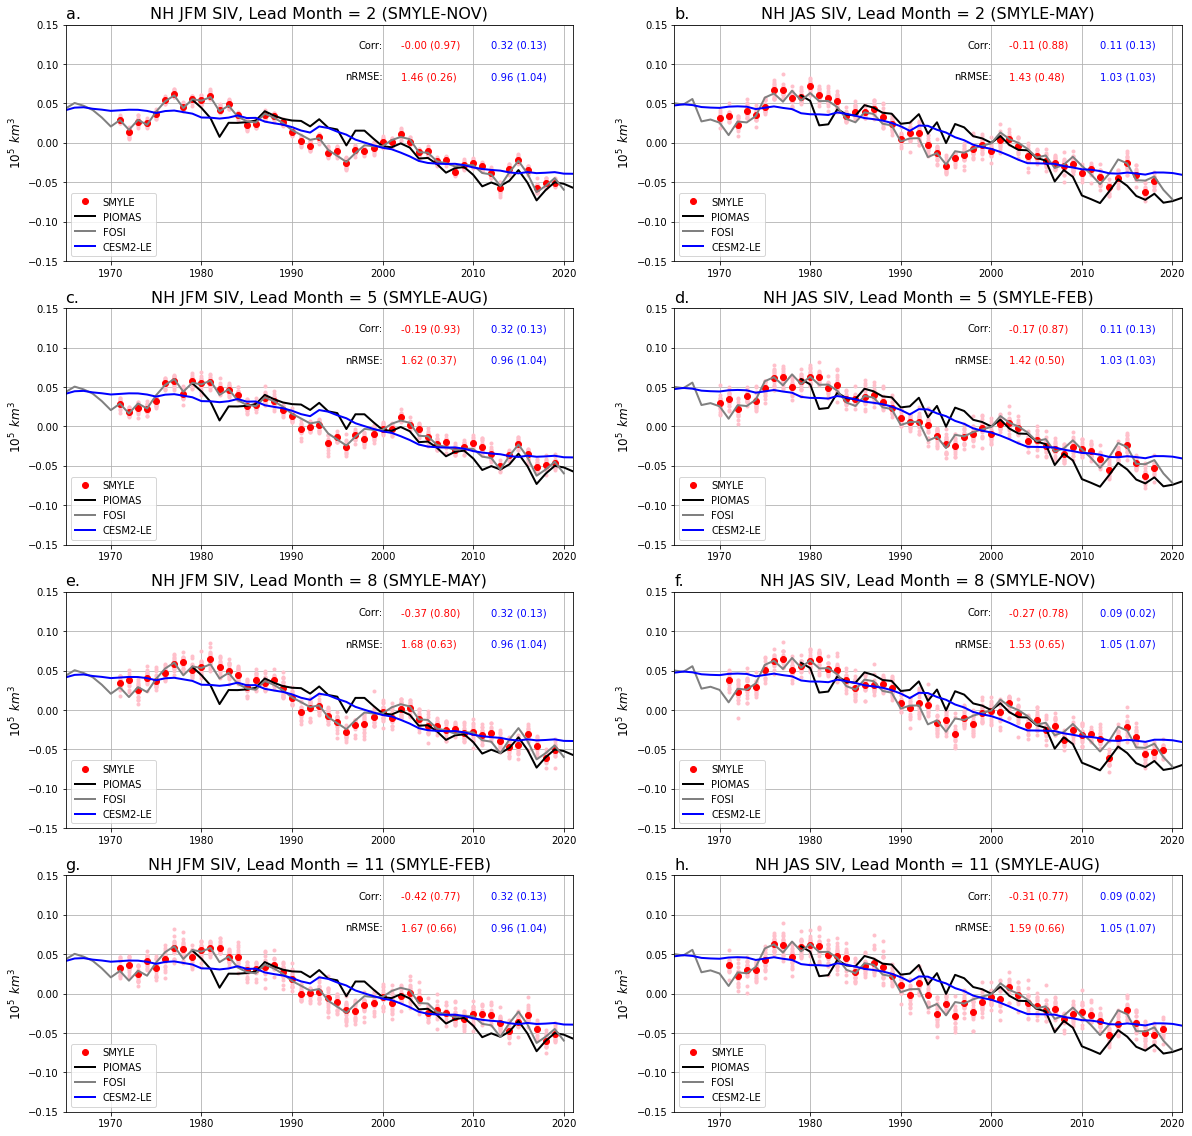

In [40]:
leads = [4,7,10,13]
nlead = np.size(leads)
fig = plt.figure(figsize=(20, nlead*5))
nrow = nlead
ncol = 2
seasons = {2:'JFM',5:'AMJ',8:'JAS',11:'OND'}

xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xticks = [cftime.num2date(0, 'days since '+str(i)+'-01-01 00:00:00', calendar='noleap') for i in xtickyears]
xmin = 1965
xmax = 2021
ymin = -0.15
ymax = 0.15

lead = leads[0]
ax = fig.add_subplot(nrow,ncol,1)
smylemon = smyle11_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle11_time.sel(L=lead).dt.year
smyledata = smyle11_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='PIOMAS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-NOV)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('a.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^5 \:\: km^{3}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,0.12,'Corr:',horizontalalignment='right',fontsize=10)
ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).corr.data,smyle11_fskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).corr2.data,smyle11_fskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',fontsize=10)
ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).rmse.data,smyle11_fskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).rmse2.data,smyle11_fskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

ax = fig.add_subplot(nrow,ncol,2)
smylemon = smyle05_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle05_time.sel(L=lead).dt.year
smyledata = smyle05_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='PIOMAS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-MAY)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('b.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^5 \:\: km^{3}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,0.12,'Corr:',horizontalalignment='right',fontsize=10)
ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).corr.data,smyle05_fskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).corr2.data,smyle05_fskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',fontsize=10)
ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).rmse.data,smyle05_fskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).rmse2.data,smyle05_fskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

lead = leads[1]
ax = fig.add_subplot(nrow,ncol,3)
smylemon = smyle08_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle08_time.sel(L=lead).dt.year
smyledata = smyle08_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='PIOMAS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-AUG)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('c.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^5 \:\: km^{3}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,0.12,'Corr:',horizontalalignment='right',fontsize=10)
ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_dt.sel(L=lead).corr.data,smyle08_fskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_dt.sel(L=lead).corr2.data,smyle08_fskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',fontsize=10)
ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_dt.sel(L=lead).rmse.data,smyle08_fskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_dt.sel(L=lead).rmse2.data,smyle08_fskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

ax = fig.add_subplot(nrow,ncol,4)
smylemon = smyle02_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle02_time.sel(L=lead).dt.year
smyledata = smyle02_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='PIOMAS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-FEB)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('d.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^5 \:\: km^{3}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,0.12,'Corr:',horizontalalignment='right',fontsize=10)
ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_dt.sel(L=lead).corr.data,smyle02_fskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_dt.sel(L=lead).corr2.data,smyle02_fskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',fontsize=10)
ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_dt.sel(L=lead).rmse.data,smyle02_fskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_dt.sel(L=lead).rmse2.data,smyle02_fskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

lead = leads[2]
ax = fig.add_subplot(nrow,ncol,5)
smylemon = smyle05_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle05_time.sel(L=lead).dt.year
smyledata = smyle05_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='PIOMAS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-MAY)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('e.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^5 \:\: km^{3}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,0.12,'Corr:',horizontalalignment='right',fontsize=10)
ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).corr.data,smyle05_fskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).corr2.data,smyle05_fskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',fontsize=10)
ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).rmse.data,smyle05_fskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).rmse2.data,smyle05_fskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

ax = fig.add_subplot(nrow,ncol,6)
smylemon = smyle11_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle11_time.sel(L=lead).dt.year
smyledata = smyle11_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='PIOMAS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-NOV)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('f.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^5 \:\: km^{3}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,0.12,'Corr:',horizontalalignment='right',fontsize=10)
ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).corr.data,smyle11_fskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).corr2.data,smyle11_fskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',fontsize=10)
ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).rmse.data,smyle11_fskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).rmse2.data,smyle11_fskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

lead = leads[3]
ax = fig.add_subplot(nrow,ncol,7)
smylemon = smyle02_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle02_time.sel(L=lead).dt.year
smyledata = smyle02_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='PIOMAS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-FEB)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('g.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^5 \:\: km^{3}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,0.12,'Corr:',horizontalalignment='right',fontsize=10)
ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_dt.sel(L=lead).corr.data,smyle02_fskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_dt.sel(L=lead).corr2.data,smyle02_fskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',fontsize=10)
ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_dt.sel(L=lead).rmse.data,smyle02_fskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle02_skill_dt.sel(L=lead).rmse2.data,smyle02_fskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

ax = fig.add_subplot(nrow,ncol,8)
smylemon = smyle08_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle08_time.sel(L=lead).dt.year
smyledata = smyle08_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='PIOMAS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-AUG)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('h.', loc='left',fontdict={'size':16})
ax.set_ylabel('$10^5 \:\: km^{3}$',fontsize=12)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,0.12,'Corr:',horizontalalignment='right',fontsize=10)
ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_dt.sel(L=lead).corr.data,smyle08_fskill_dt.sel(L=lead).corr.data),color='red',fontsize=10)
ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_dt.sel(L=lead).corr2.data,smyle08_fskill_dt.sel(L=lead).corr2.data),color='blue',fontsize=10)
ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',fontsize=10)
ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_dt.sel(L=lead).rmse.data,smyle08_fskill_dt.sel(L=lead).rmse.data),color='red',fontsize=10)
ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle08_skill_dt.sel(L=lead).rmse2.data,smyle08_fskill_dt.sel(L=lead).rmse2.data),color='blue',fontsize=10)

plt.savefig('NH_SIV_skill.png')

In [66]:
smyle11_siv_dd.L

<xarray.DataArray 'L' (L: 8)>
array([ 1,  4,  7, 10, 13, 16, 19, 22])
Coordinates:
  * L        (L) int64 1 4 7 10 13 16 19 22
    units    <U4 'km^2'

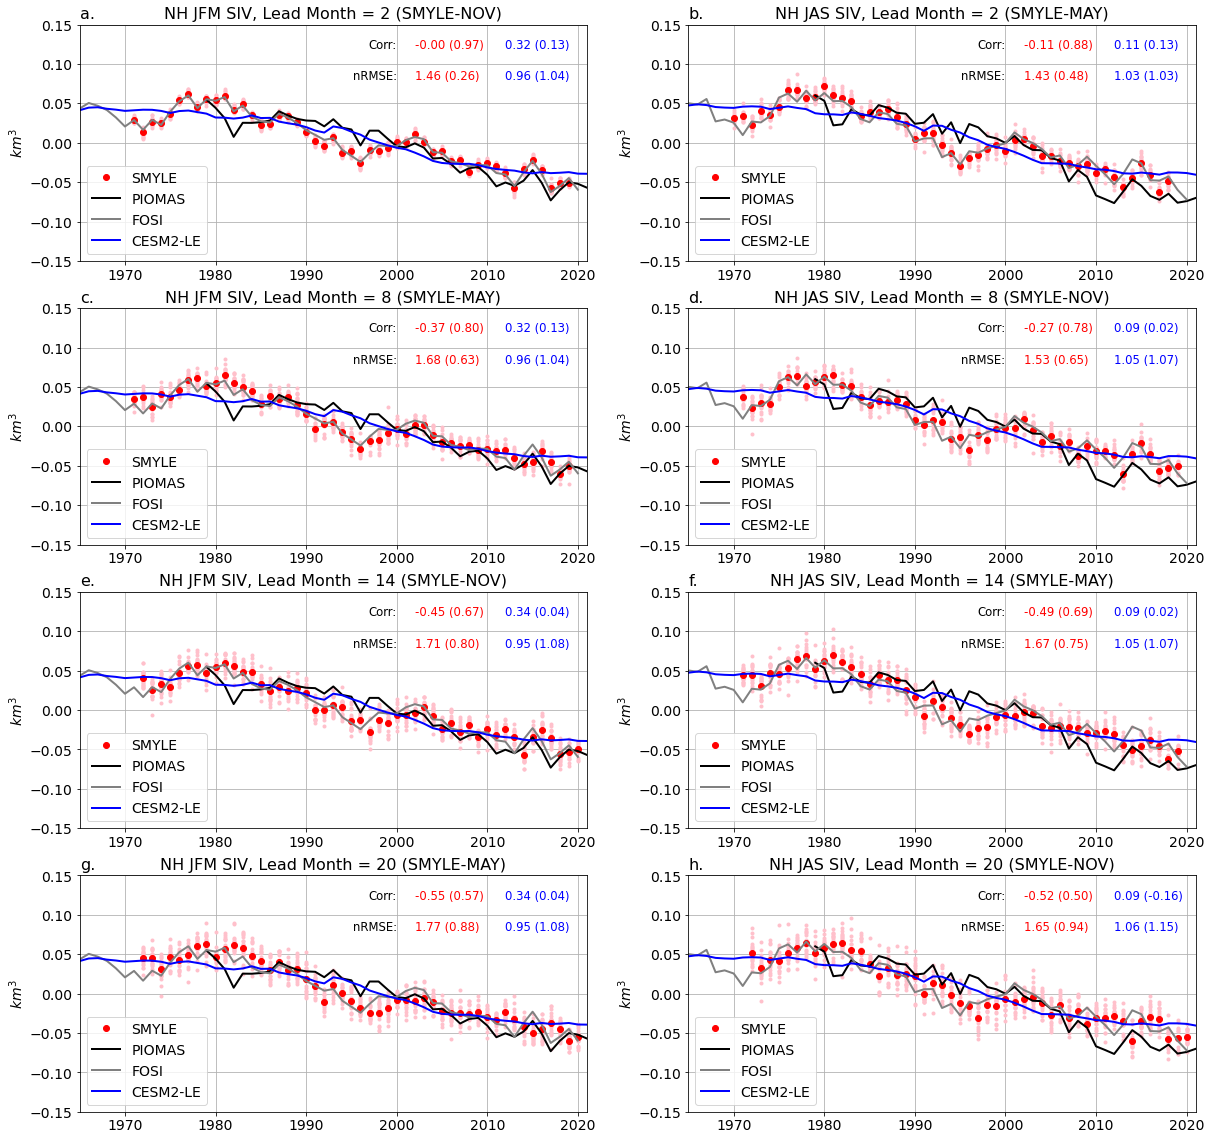

In [69]:
leads = [4,10,16,22]
nlead = np.size(leads)
fig = plt.figure(figsize=(20, nlead*5))
nrow = nlead
ncol = 2
seasons = {2:'JFM',5:'AMJ',8:'JAS',11:'OND'}

xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xticks = [cftime.num2date(0, 'days since '+str(i)+'-01-01 00:00:00', calendar='noleap') for i in xtickyears]
xmin = 1965
xmax = 2021
ymin = -0.15
ymax = 0.15

lead = leads[0]
ax = fig.add_subplot(nrow,ncol,1)
smylemon = smyle11_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle11_time.sel(L=lead).dt.year
smyledata = smyle11_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='PIOMAS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-NOV)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('a.', loc='left',fontdict={'size':16})
ax.set_ylabel(r'$km^{3}$')
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,0.12,'Corr:',horizontalalignment='right',size='small')
ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).corr.data,smyle11_fskill_dt.sel(L=lead).corr.data),color='red',size='small')
ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).corr2.data,smyle11_fskill_dt.sel(L=lead).corr2.data),color='blue',size='small')
ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',size='small')
ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).rmse.data,smyle11_fskill_dt.sel(L=lead).rmse.data),color='red',size='small')
ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).rmse2.data,smyle11_fskill_dt.sel(L=lead).rmse2.data),color='blue',size='small')

ax = fig.add_subplot(nrow,ncol,2)
smylemon = smyle05_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle05_time.sel(L=lead).dt.year
smyledata = smyle05_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='PIOMAS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-MAY)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('b.', loc='left',fontdict={'size':16})
ax.set_ylabel(r'$km^{3}$')
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,0.12,'Corr:',horizontalalignment='right',size='small')
ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).corr.data,smyle05_fskill_dt.sel(L=lead).corr.data),color='red',size='small')
ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).corr2.data,smyle05_fskill_dt.sel(L=lead).corr2.data),color='blue',size='small')
ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',size='small')
ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).rmse.data,smyle05_fskill_dt.sel(L=lead).rmse.data),color='red',size='small')
ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).rmse2.data,smyle05_fskill_dt.sel(L=lead).rmse2.data),color='blue',size='small')

lead = leads[1]
ax = fig.add_subplot(nrow,ncol,3)
smylemon = smyle05_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle05_time.sel(L=lead).dt.year
smyledata = smyle05_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='PIOMAS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-MAY)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('c.', loc='left',fontdict={'size':16})
ax.set_ylabel(r'$km^{3}$')
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,0.12,'Corr:',horizontalalignment='right',size='small')
ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).corr.data,smyle05_fskill_dt.sel(L=lead).corr.data),color='red',size='small')
ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).corr2.data,smyle05_fskill_dt.sel(L=lead).corr2.data),color='blue',size='small')
ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',size='small')
ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).rmse.data,smyle05_fskill_dt.sel(L=lead).rmse.data),color='red',size='small')
ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).rmse2.data,smyle05_fskill_dt.sel(L=lead).rmse2.data),color='blue',size='small')

ax = fig.add_subplot(nrow,ncol,4)
smylemon = smyle11_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle11_time.sel(L=lead).dt.year
smyledata = smyle11_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='PIOMAS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-NOV)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('d.', loc='left',fontdict={'size':16})
ax.set_ylabel(r'$km^{3}$')
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,0.12,'Corr:',horizontalalignment='right',size='small')
ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).corr.data,smyle11_fskill_dt.sel(L=lead).corr.data),color='red',size='small')
ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).corr2.data,smyle11_fskill_dt.sel(L=lead).corr2.data),color='blue',size='small')
ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',size='small')
ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).rmse.data,smyle11_fskill_dt.sel(L=lead).rmse.data),color='red',size='small')
ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).rmse2.data,smyle11_fskill_dt.sel(L=lead).rmse2.data),color='blue',size='small')

lead = leads[2]
ax = fig.add_subplot(nrow,ncol,5)
smylemon = smyle11_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle11_time.sel(L=lead).dt.year
smyledata = smyle11_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='PIOMAS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-NOV)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('e.', loc='left',fontdict={'size':16})
ax.set_ylabel(r'$km^{3}$')
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,0.12,'Corr:',horizontalalignment='right',size='small')
ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).corr.data,smyle11_fskill_dt.sel(L=lead).corr.data),color='red',size='small')
ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).corr2.data,smyle11_fskill_dt.sel(L=lead).corr2.data),color='blue',size='small')
ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',size='small')
ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).rmse.data,smyle11_fskill_dt.sel(L=lead).rmse.data),color='red',size='small')
ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).rmse2.data,smyle11_fskill_dt.sel(L=lead).rmse2.data),color='blue',size='small')

ax = fig.add_subplot(nrow,ncol,6)
smylemon = smyle05_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle05_time.sel(L=lead).dt.year
smyledata = smyle05_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='PIOMAS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-MAY)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('f.', loc='left',fontdict={'size':16})
ax.set_ylabel(r'$km^{3}$')
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,0.12,'Corr:',horizontalalignment='right',size='small')
ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).corr.data,smyle05_fskill_dt.sel(L=lead).corr.data),color='red',size='small')
ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).corr2.data,smyle05_fskill_dt.sel(L=lead).corr2.data),color='blue',size='small')
ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',size='small')
ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).rmse.data,smyle05_fskill_dt.sel(L=lead).rmse.data),color='red',size='small')
ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).rmse2.data,smyle05_fskill_dt.sel(L=lead).rmse2.data),color='blue',size='small')

lead = leads[3]
ax = fig.add_subplot(nrow,ncol,7)
smylemon = smyle05_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle05_time.sel(L=lead).dt.year
smyledata = smyle05_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjfm.time, obsjfm,linewidth=2,color='k',label='PIOMAS')
ax.plot(fosijfm.time, fosijfm,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jfm.time, cesm2jfm,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-MAY)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('g.', loc='left',fontdict={'size':16})
ax.set_ylabel(r'$km^{3}$')
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,0.12,'Corr:',horizontalalignment='right',size='small')
ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).corr.data,smyle05_fskill_dt.sel(L=lead).corr.data),color='red',size='small')
ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).corr2.data,smyle05_fskill_dt.sel(L=lead).corr2.data),color='blue',size='small')
ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',size='small')
ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).rmse.data,smyle05_fskill_dt.sel(L=lead).rmse.data),color='red',size='small')
ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle05_skill_dt.sel(L=lead).rmse2.data,smyle05_fskill_dt.sel(L=lead).rmse2.data),color='blue',size='small')

ax = fig.add_subplot(nrow,ncol,8)
smylemon = smyle11_time.sel(L=lead).dt.month.data[0]
smyleyear = smyle11_time.sel(L=lead).dt.year
smyledata = smyle11_siv_dd.sel(L=lead)*scalefact
ax.plot(smyleyear,smyledata,'.',color='pink')
ax.plot(smyleyear,smyledata.mean('M'),'o',color='r',label='SMYLE')
ax.plot(obsjas.time, obsjas,linewidth=2,color='k',label='PIOMAS')
ax.plot(fosijas.time, fosijas,linewidth=2,color='grey',label='FOSI')
ax.plot(cesm2jas.time, cesm2jas,linewidth=2,color='blue',label='CESM2-LE')
ax.grid()
ax.set_title('NH {} SIV, Lead Month = {} (SMYLE-NOV)'.format(seasons[smylemon],lead-2), fontdict={'size':16})
ax.set_title('h.', loc='left',fontdict={'size':16})
ax.set_ylabel(r'$km^{3}$')
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.legend(loc='lower left')
ax.text(2000,0.12,'Corr:',horizontalalignment='right',size='small')
ax.text(2002,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).corr.data,smyle11_fskill_dt.sel(L=lead).corr.data),color='red',size='small')
ax.text(2012,0.12,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).corr2.data,smyle11_fskill_dt.sel(L=lead).corr2.data),color='blue',size='small')
ax.text(2000,0.08,'nRMSE:',horizontalalignment='right',size='small')
ax.text(2002,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).rmse.data,smyle11_fskill_dt.sel(L=lead).rmse.data),color='red',size='small')
ax.text(2012,0.08,'{0:3.2f} ({1:3.2f})'.format(smyle11_skill_dt.sel(L=lead).rmse2.data,smyle11_fskill_dt.sel(L=lead).rmse2.data),color='blue',size='small')

plt.savefig('NH_SIV_skill.png')